Before we begin, let's retrieve some audio files of songs. The best file to work with in Python is .mav. In the genres_original folder we can find some test data for our algorithm.

if you have .mp3 file you can use this code in terminal to convert it into .mav

``` Terminal
ls *.mp3 | rg -o "(.*?)\.mp3" -r '$1' | xargs -n 1 -I '{}' -d '\n' ffmpeg -i '{}.mp3' -ac 1 'converted/{}.wav
```

## Create Fingerprints

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set default display parameters
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 140

import scipy
from scipy import fft, signal
from scipy.io.wavfile import read

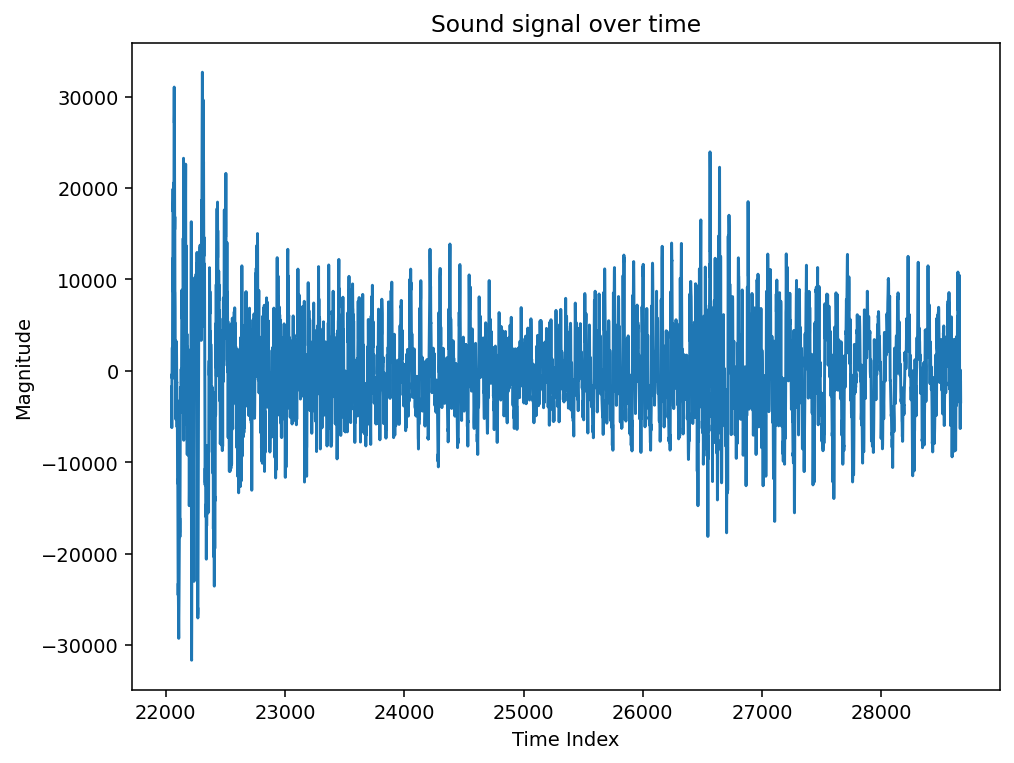

In [2]:
# Read .wav files
Fs, song = read("genres_original/hiphop/hiphop.00004.wav") # --> insert file .mav here
time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int) # --> It starts at Fs * 1 (1 second) and ends at Fs * 1.3 (1.3 seconds)

# plot signal against time in seconds.
plt.plot(time_to_plot, song[time_to_plot])
plt.title('Sound signal over time')
plt.xlabel('Time Index')
plt.ylabel('Magnitude')
plt.show()

Problems with this graph:
1. There is a lot of high frequency noise --> difficult to identify peaks
2. Any background noise will be indistinguishable from the main song

### Fourier Analysis

Fourier analysis breaks down complex audio signals into their frequency components, essential for visualizing and extracting features like dominant frequencies and rhythmic patterns. This information enables comparing tracks, aiding in music recognition algorithms.

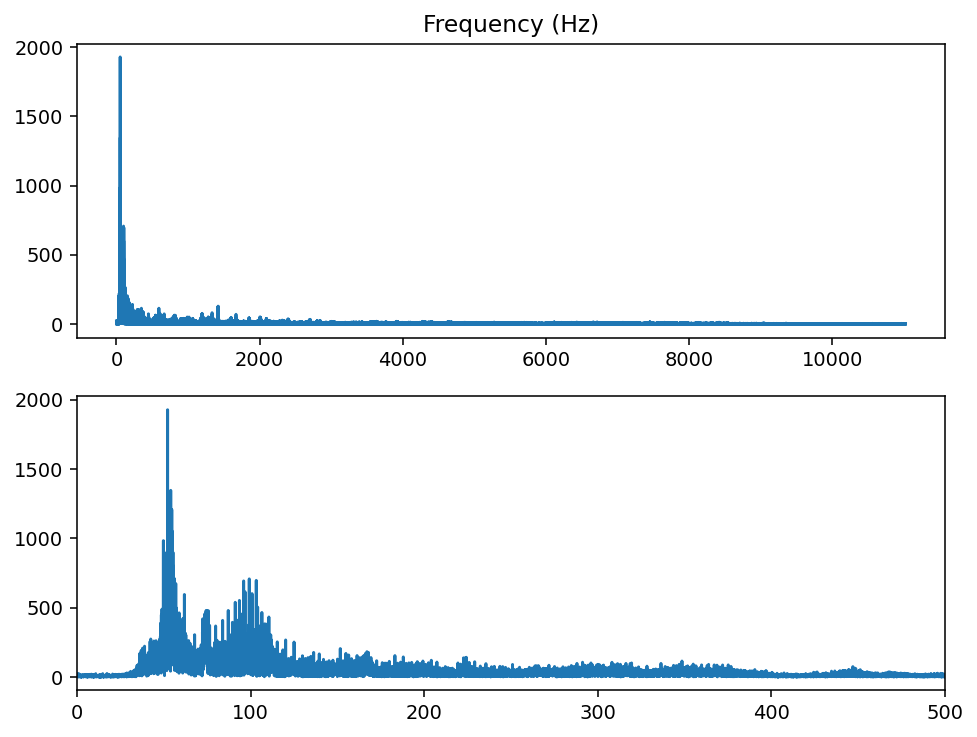

In [3]:
# Fast Fourier Transform (FFT) to analyze the frequency content of the audio signal
from scipy.fft import fftfreq

N = len(song)
fft = scipy.fft.fft(song) # complex-valued array representing the frequency domain

# magnitude of the FFT output (the amplitude spectrum) up to the Nyquist frequency (half of the sampling frequency) --> Normalization
transform_y = 2.0 / N * np.abs(fft[0:N//2])
# Generates the frequency values corresponding to the FFT
transform_x = scipy.fft.fftfreq(N, 1/Fs)[:N//2] 

# Plot
plt.subplot(2, 1, 1)
plt.title('Frequency (Hz)')
plt.plot(transform_x, transform_y)

plt.subplot(2,1,2)
plt.plot(transform_x, transform_y)
plt.xlim(0, 500)

plt.show()

###  find peaks in the spectrum

music tends to have it's strongest peaks in the lower frequency range (< 500Hz), so a peak finding method that only considers the most prominent peaks (peaks with the shallowest 'valley' on either side) will have it's peaks concentrated in the bass frequencies. 

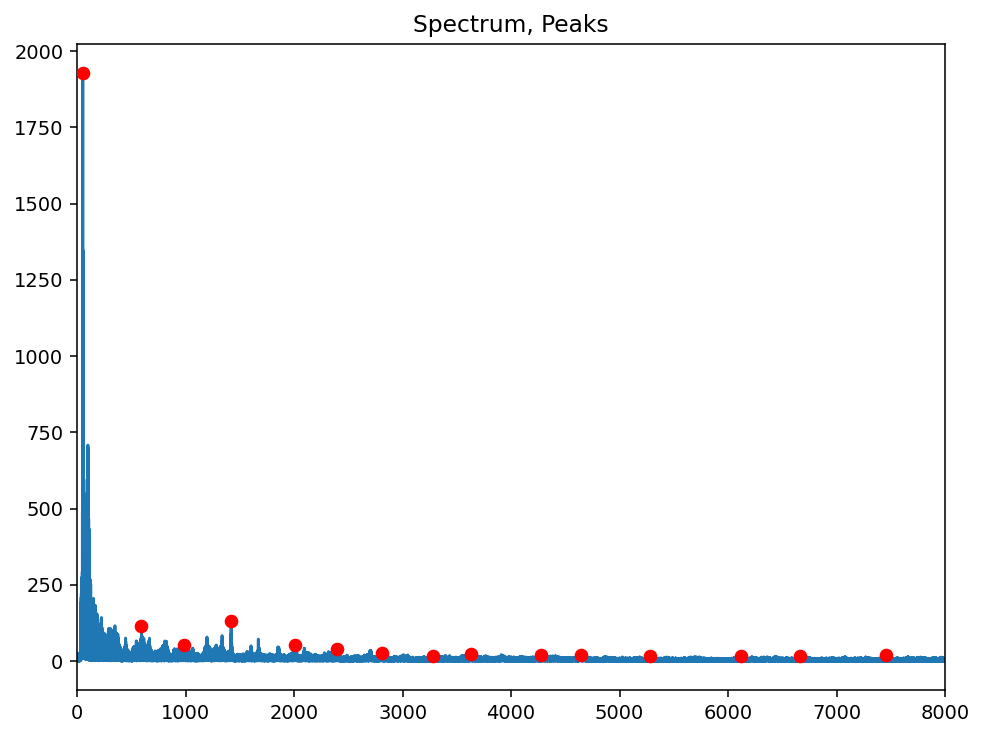

In [4]:
all_peaks, props = signal.find_peaks(transform_y)  # detects all peaks in the transform_y. The function returns the indices of all peaks found (all_peaks) and properties of the detected peaks (props).
peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000) # prominence parameter sets a minimum prominence of peaks, distance parameter specifies the minimum horizontal distance between adjacent peaks.
n_peaks = 15 # --> try to modify and see how peaks change

# Get the n_peaks largest peaks from the prominences
# This is an argpartition
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
largest_peaks = peaks[largest_peaks_indices] # indices of the largest peaks from the peaks

plt.plot(transform_x, transform_y, label="Spectrum")
plt.title('Spectrum, Peaks')
plt.scatter(transform_x[largest_peaks], transform_y[largest_peaks], color="r", zorder=10, label="Constrained Peaks")
plt.xlim(0, 8000)

plt.show()

Peak frequencies extracted through Fourier analysis offer a succinct representation of the analyzed sound. However, scrutinizing the entire song at once risks overlooking nuances in sound, such as variations between the chorus and final verse. Additionally, brief audio snippets, like those captured on a user's phone, may inadequately capture the full frequency spectrum of the song.

To surmount this challenge, the Short Time Fourier Transform (STFT) from SciPy presents a solution. This method dissects the song into brief segments, typically lasting half a second, and applies Fourier Transform to each segment independently. By identifying prominent frequencies within each snippet, we capture the dynamic evolution of the song's frequency composition over time. Consequently, irrespective of the portion sampled, we can match it to its corresponding snippet, enhancing the accuracy of recognition. The STFT accomplishes this by applying the Fourier Transform in windows with slight overlap between consecutive segments, enabling a comprehensive analysis of temporal variations in frequency content.

In [5]:
# Some parameters
window_length_seconds = 3
window_length_samples = int(window_length_seconds * Fs)
window_length_samples += window_length_samples % 2
# Perform a short time fourier transform
# frequencies and times are references for plotting/analysis later
# the stft is a NxM matrix
frequencies, times, stft = signal.stft(
    song, Fs, nperseg=window_length_samples,
    nfft=window_length_samples, return_onesided=True
)
stft.shape

(33076, 22)

After identifying the largest peaks in the frequency spectrum, we can extend our analysis by mapping these peaks over time. By applying the same peak detection technique across smaller segments of the audio signal, we can create a graph where time is represented along the X-axis and the frequency of each peak is plotted along the Y-axis. This graphical representation forms a constellation of points that uniquely characterizes the song. Each point in this constellation corresponds to a peak frequency at a specific moment in time, providing a dynamic portrayal of the song's frequency content as it evolves over its duration.

### Costellation (few points)
The aim of this constellation is to be entirely unique, with no other song having the same. This method create a plot more sensible to difference

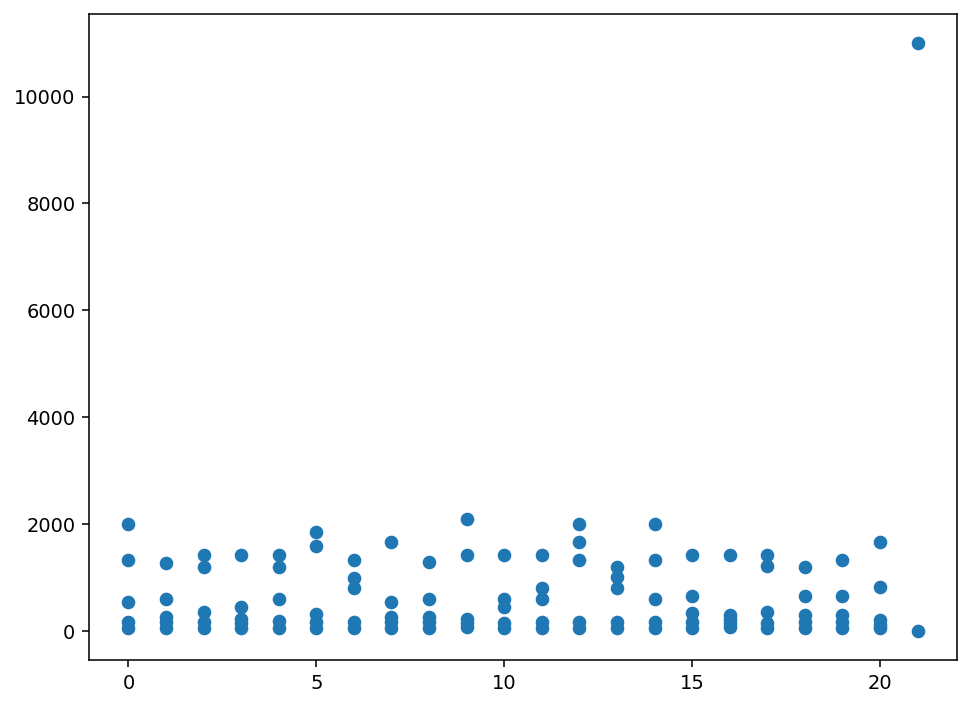

In [6]:
constellation_map = []
for time_idx, window in enumerate(stft.T):
    # Spectrum is by default complex. 
    # We want real values only
    spectrum = abs(window)
    # Find peaks - these correspond to interesting features
    # Note the distance - want an even spread across the spectrum
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)
    # Only want the most prominent peaks
    # With a maximum of 5 per time slice
    n_peaks = min(5, len(peaks)) # --> check if this value is less than len(peaks) or its not working!
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        constellation_map.append([time_idx, frequency])

# Transform [(x, y), ...] into ([x1, x2...], [y1, y2...]) for plotting using zip
plt.scatter(*zip(*constellation_map))
plt.show()

### Costellation (tweaked Parameters) - best method

In [7]:
def create_constellation(audio, Fs):
    # Parameters
    window_length_seconds = 0.5
    window_length_samples = int(window_length_seconds * Fs)
    window_length_samples += window_length_samples % 2
    num_peaks = 15
    # Pad the song to divide evenly into windows
    amount_to_pad = window_length_samples - audio.size % window_length_samples
    song_input = np.pad(audio, (0, amount_to_pad))
    # Perform a short time fourier transform
    frequencies, times, stft = signal.stft(
        song_input, Fs, nperseg=window_length_samples, nfft=window_length_samples, return_onesided=True
    )
    constellation_map = []
    for time_idx, window in enumerate(stft.T):
        spectrum = abs(window)
        peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)
        n_peaks = min(num_peaks, len(peaks))
        largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
        for peak in peaks[largest_peaks]:
            frequency = frequencies[peak]
            constellation_map.append([time_idx, frequency])
    return constellation_map

In [8]:
create_constellation(song, Fs)[0:50]

[[0, 3001.727734445855],
 [0, 5601.49192816978],
 [0, 2555.768184291674],
 [0, 4677.575730092508],
 [0, 559.9492109559224],
 [0, 3547.6782151278794],
 [0, 6121.444766914565],
 [0, 6667.395247596589],
 [0, 7449.324324324323],
 [0, 7951.278795574097],
 [0, 1347.8777435153272],
 [0, 9039.180119717032],
 [0, 5187.529475784509],
 [0, 8419.236350444404],
 [0, 53.99510248503537],
 [1, 9047.179394159259],
 [1, 4855.559586432069],
 [1, 6341.42481407582],
 [1, 4203.618719390531],
 [1, 3447.687284600036],
 [1, 7703.301287865045],
 [1, 5729.480319245419],
 [1, 6963.3684019590055],
 [1, 5275.5214946490105],
 [1, 561.9490295664792],
 [1, 8425.235806276074],
 [1, 3021.7259205514238],
 [1, 2015.8171594413202],
 [1, 1345.8779249047705],
 [1, 53.99510248503537],
 [2, 9045.179575548702],
 [2, 7053.360239434064],
 [2, 7789.29348811899],
 [2, 4623.580627607473],
 [2, 8425.235806276074],
 [2, 5051.541810266642],
 [2, 6411.41846544531],
 [2, 3449.687103210593],
 [2, 4031.6343188826404],
 [2, 5727.48050063486

## Combinatorial Hashing

The constellation map points serve as the foundation for creating combinatorial associations, wherein each point pairs with multiple others to establish frequency pairs, stored alongside their time interval disparities.
By converting these frequencies into 10-bit integers (ranging from 0 to 1024, mapping exact frequencies to bins) and representing the time difference with a 12-bit integer, each pair of points yields a singular 32-bit integer hash.
This method significantly augments the pool of potential fingerprints for a song compared to relying solely on constellations. Moreover, it boasts exceptional computational efficiency for matching hashes between cell phone recordings and the song database.
Creating these associations is straightforward: for any given point within the constellation, scan for a set of subsequent points within a defined range (e.g., up to 10 sampling windows forward). These pairs constitute the fingerprint pairs.
Storing this hash involves associating it with the track ID and the time of its occurrence, crucial for subsequent processes.

In [9]:
constellation_map = create_constellation(song, Fs)
def create_hashes(constellation_map, song_id=None):
    hashes = {}
    # Use this for binning - 23_000 is slighlty higher than the maximum
    # frequency that can be stored in the .wav files, 22.05 kHz
    upper_frequency = 23_000 
    frequency_bits = 10
    # Iterate the constellation
    for idx, (time, freq) in enumerate(constellation_map):
        # Iterate the next 100 pairs to produce the combinatorial hashes
        # When we produced the constellation before, it was sorted by time already
        # So this finds the next n points in time (though they might occur at the same time)
        for other_time, other_freq in constellation_map[idx : idx + 100]: 
            diff = other_time - time
            # If the time difference between the pairs is too small or large
            # ignore this set of pairs
            if diff <= 1 or diff > 10:
                continue
            # Place the frequencies (in Hz) into a 1024 bins
            freq_binned = freq / upper_frequency * (2 ** frequency_bits)
            other_freq_binned = other_freq / upper_frequency * (2 ** frequency_bits)
            # Produce a 32 bit hash
            # Use bit shifting to move the bits to the correct location
            hash = int(freq_binned) | (int(other_freq_binned) << 10) | (int(diff) << 20)
            hashes[hash] = (time, song_id)
    return hashes

In [10]:
# Quickly investigate some of the hashes produced
hashes = create_hashes(constellation_map, 0)
for i, (hash, (time, _)) in enumerate(hashes.items()):
    if i > 10: 
        break
    print(f"Hash {hash} occurred at {time}")

Hash 2508933 occurred at 109
Hash 2418821 occurred at 0
Hash 2451589 occurred at 109
Hash 2307205 occurred at 0
Hash 2481285 occurred at 109
Hash 2326661 occurred at 0
Hash 2389125 occurred at 109
Hash 2253957 occurred at 46
Hash 2280581 occurred at 0
Hash 2357381 occurred at 109
Hash 2121861 occurred at 0


### Generating a Simple Hash Database

generate a database of all hashes across our folder of songs. We use a hashmap saved with Pickle

In [11]:
import glob
from typing import List, Dict, Tuple
from tqdm import tqdm
import pickle

songs = glob.glob('genres_original/hiphop/*.wav') # --> upload here the folder with our .wav files
song_name_index = {}
database: Dict[int, List[Tuple[int, int]]] = {}

# Go through each song, using where they are alphabetically as an id
for index, filename in enumerate(tqdm(sorted(songs))):
    song_name_index[index] = filename
    # Read the song, create a constellation and hashes
    Fs, audio_input = read(filename)
    constellation = create_constellation(audio_input, Fs)
    hashes = create_hashes(constellation, index)
    # For each hash, append it to the list for this hash
    for hash, time_index_pair in hashes.items():
        if hash not in database:
            database[hash] = []
        database[hash].append(time_index_pair)
# Dump the database and list of songs as pickles
with open("database.pickle", 'wb') as db:
    pickle.dump(database, db, pickle.HIGHEST_PROTOCOL)
with open("song_index.pickle", 'wb') as songs:
    pickle.dump(song_name_index, songs, pickle.HIGHEST_PROTOCOL)

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


this is how to visualize the database that we have create. This is computationaly difficult so attention:

``` python
import pickle

# upload database
with open("database.pickle", 'rb') as db_file:
    database = pickle.load(db_file)

# upload song index
with open("song_index.pickle", 'rb') as songs_file:
    song_name_index = pickle.load(songs_file)

# Viusalize
for hash_value, time_index_pairs in database.items():
    print("Hash:", hash_value)
    for time_index_pair in time_index_pairs:
        song_index, time_index = time_index_pair
        if song_index in song_name_index:
            song_name = song_name_index[song_index]
            print("\tSong:", song_name, "\tTime Index:", time_index)
        else:
            print("\tSong index", song_index, "not found in song_name_index")
```

### Finding matches for recordings

In [12]:
# Load the database
database = pickle.load(open('database.pickle', 'rb'))
song_name_index = pickle.load(open("song_index.pickle", "rb"))

# Load a song
Fs, audio_input = read("genres_original/hiphop/hiphop.00004.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)
# For each hash in the song, check if there's a match in the database
# There could be multiple matching tracks, so for each match, incrememnt a counter for that song ID by one
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = 0
            matches_per_song[song_id] += 1
for song_id, num_matches in list(sorted(matches_per_song.items(), key=lambda x: x[1], reverse=True))[:10]:
    print(f"Song: {song_name_index[song_id]} - Matches: {num_matches}")

Song: genres_original/hiphop/hiphop.00004.wav - Matches: 84211
Song: genres_original/hiphop/hiphop.00083.wav - Matches: 15139
Song: genres_original/hiphop/hiphop.00022.wav - Matches: 14303
Song: genres_original/hiphop/hiphop.00091.wav - Matches: 13974
Song: genres_original/hiphop/hiphop.00024.wav - Matches: 13320
Song: genres_original/hiphop/hiphop.00015.wav - Matches: 13313
Song: genres_original/hiphop/hiphop.00021.wav - Matches: 13076
Song: genres_original/hiphop/hiphop.00092.wav - Matches: 13061
Song: genres_original/hiphop/hiphop.00018.wav - Matches: 13054
Song: genres_original/hiphop/hiphop.00027.wav - Matches: 13054


As we can observe, the result reports the a large number of matches with the inserted song

In [13]:
# Load a short recording with some background noise
Fs, audio_input = read("genres_original/hiphop/hiphop.00004.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)
# For each hash in the song, check if there's a match in the database
# There could be multiple matches, so for each match:
#   Append all of them to a hashmap based on the song id along with the time
#   the hash occurs in the sample and at the source
# In the end, matches_per_song is key'd by song ID with values being
# lists of hashes, the 
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = []
            matches_per_song[song_id].append((hash, sample_time, source_time))

Total matches for hiphop.00069.wav: 10177
Total matches for hiphop.00000.wav: 11351


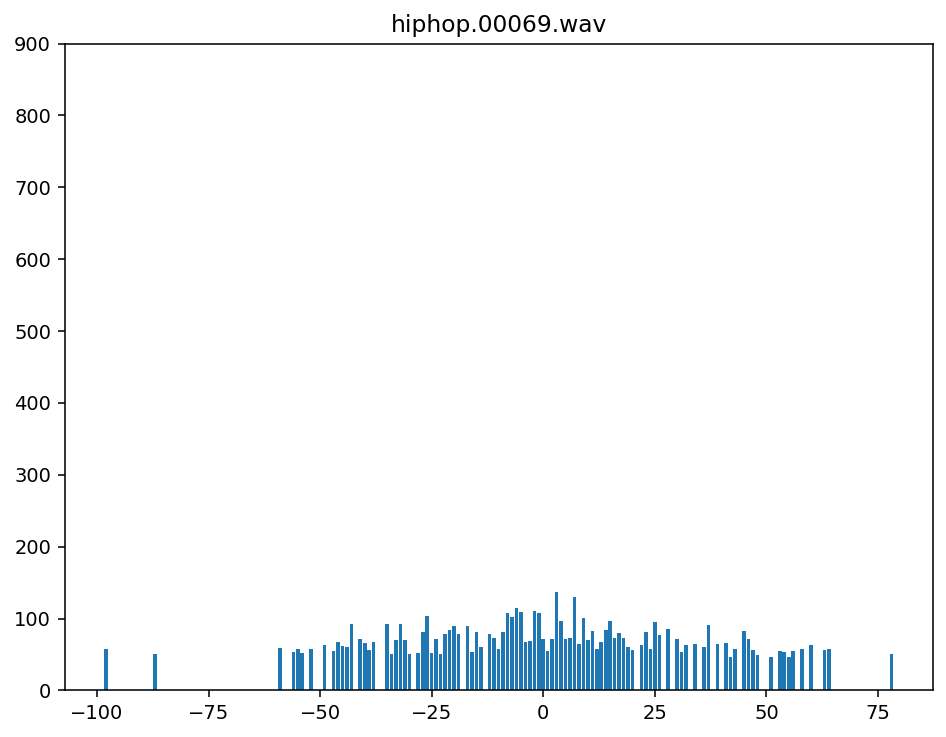

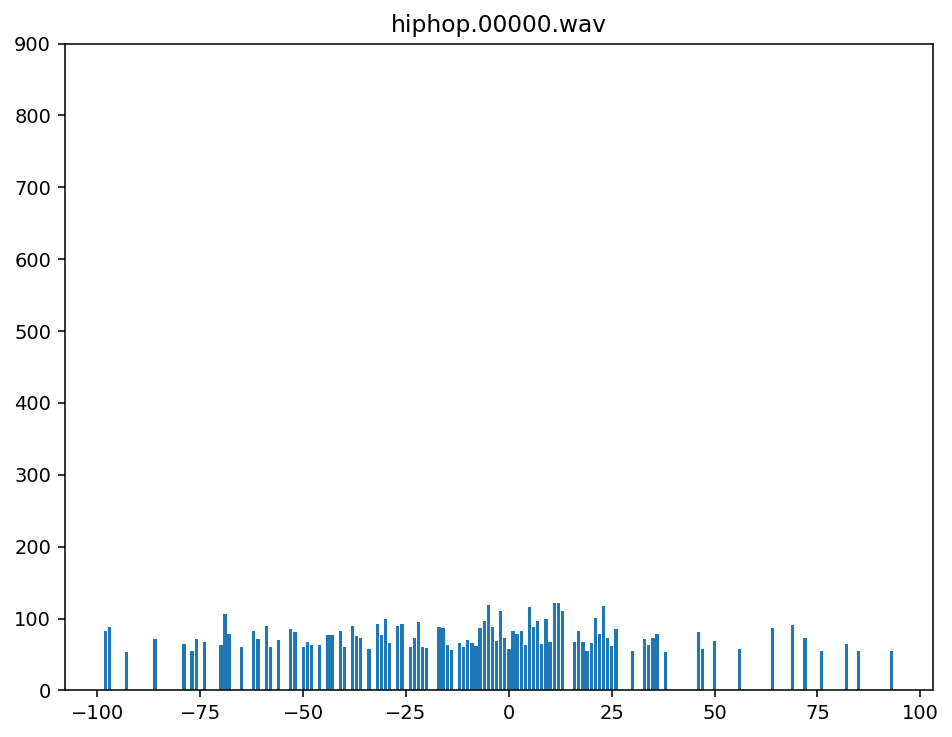

In [14]:
scores = {}
song_ids = [69, 0] # Song ID=0 is the true match
for song_id in song_ids:
    song_name = song_name_index[song_id].split('genres_original/hiphop/')[1]
    matches = matches_per_song[song_id]
    print(f"Total matches for {song_name}: {len(matches)}")
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1
    # Produce a histogram
    # For clarity's sake, only plot the 100 largest offsets
    high_scores = list(sorted(song_scores_by_offset.items(), key=lambda x: x[1], reverse=True))[:100]
    plt.figure()
    plt.bar(*zip(*high_scores))
    plt.title(song_name)
    plt.ylim((0, 900))

In [15]:
for i in range(20):
   print(song_name_index[i])

genres_original/hiphop/hiphop.00000.wav
genres_original/hiphop/hiphop.00001.wav
genres_original/hiphop/hiphop.00002.wav
genres_original/hiphop/hiphop.00003.wav
genres_original/hiphop/hiphop.00004.wav
genres_original/hiphop/hiphop.00005.wav
genres_original/hiphop/hiphop.00006.wav
genres_original/hiphop/hiphop.00007.wav
genres_original/hiphop/hiphop.00008.wav
genres_original/hiphop/hiphop.00009.wav
genres_original/hiphop/hiphop.00010.wav
genres_original/hiphop/hiphop.00011.wav
genres_original/hiphop/hiphop.00012.wav
genres_original/hiphop/hiphop.00013.wav
genres_original/hiphop/hiphop.00014.wav
genres_original/hiphop/hiphop.00015.wav
genres_original/hiphop/hiphop.00016.wav
genres_original/hiphop/hiphop.00017.wav
genres_original/hiphop/hiphop.00018.wav
genres_original/hiphop/hiphop.00019.wav


This method to find a match can be extended to all songs, with each song being assigned a score based on the largest peak in it's histogram.

In [16]:
scores = {}
for song_index, matches in matches_per_song.items():
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1
    max = (0, 0)
    for offset, score in song_scores_by_offset.items():
        if score > max[1]:
            max = (offset, score)
    
    scores[song_index] = max
for song_index, score in list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True))[:5]:
    print(f"{song_name_index[song_index]}: Score of {score[1]} at {score[0]}")

genres_original/hiphop/hiphop.00004.wav: Score of 84211 at 0
genres_original/hiphop/hiphop.00027.wav: Score of 261 at 7
genres_original/hiphop/hiphop.00066.wav: Score of 236 at -8
genres_original/hiphop/hiphop.00020.wav: Score of 220 at -8
genres_original/hiphop/hiphop.00082.wav: Score of 205 at -2


final method

In [17]:
def score_hashes_against_database(hashes):
    matches_per_song = {}
    for hash, (sample_time, _) in hashes.items():
        if hash in database:
            matching_occurences = database[hash]
            for source_time, song_index in matching_occurences:
                if song_index not in matches_per_song:
                    matches_per_song[song_index] = []
                matches_per_song[song_index].append((hash, sample_time, source_time))
            
    # %%
    scores = {}
    for song_index, matches in matches_per_song.items():
        song_scores_by_offset = {}
        for hash, sample_time, source_time in matches:
            delta = source_time - sample_time
            if delta not in song_scores_by_offset:
                song_scores_by_offset[delta] = 0
            song_scores_by_offset[delta] += 1
        max = (0, 0)
        for offset, score in song_scores_by_offset.items():
            if score > max[1]:
                max = (offset, score)
        
        scores[song_index] = max
    # Sort the scores for the user
    scores = list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True)) 
    
    return scores

### Tests

In [18]:
def print_top_five(file_name):
    # Load a short recording with some background noise
    Fs, audio_input = read(file_name)
    # Create the constellation and hashes
    constellation = create_constellation(audio_input, Fs)
    hashes = create_hashes(constellation, None)
    scores = score_hashes_against_database(hashes)[:5]
    for song_id, score in scores:
        print(f"{song_name_index[song_id]}: Score of {score[1]} at {score[0]}")

In [19]:
print("Song 1:")
print_top_five("genres_original/hiphop/hiphop.00084.wav")

Song 1:
genres_original/hiphop/hiphop.00084.wav: Score of 81737 at 0
genres_original/hiphop/hiphop.00089.wav: Score of 279 at -11
genres_original/hiphop/hiphop.00091.wav: Score of 247 at 15
genres_original/hiphop/hiphop.00024.wav: Score of 219 at -11
genres_original/hiphop/hiphop.00093.wav: Score of 214 at 10


In [20]:
print("Song 2:")
print_top_five("genres_original/hiphop/hiphop.00027.wav")

Song 2:
genres_original/hiphop/hiphop.00027.wav: Score of 95458 at 0
genres_original/hiphop/hiphop.00020.wav: Score of 281 at 0
genres_original/hiphop/hiphop.00004.wav: Score of 261 at -7
genres_original/hiphop/hiphop.00059.wav: Score of 246 at -6
genres_original/hiphop/hiphop.00003.wav: Score of 245 at 15


### Conclusions

There's a plethora of potential optimizations to enhance the efficiency in terms of both time and storage across various stages. Furthermore, there's undoubtedly room for refinement in the Fourier analysis to optimize its performance across a broader spectrum of environments. Nonetheless, this implementation remains fundamentally functional.

Comparatively, contemporary iterations of Shazam or proprietary versions like Google's have undoubtedly undergone significant evolution since 2002. For instance, Google's iteration can discern a song merely from a user humming the melody, a feat unattainable by this implementation. Notably, users of Shazam have observed its sensitivity to minute alterations in timing or pitch, leading to discrepancies in matching live performances to their studio recordings in the database. Exploiting such nuances could potentially expose artists who mime to prerecorded tracks, as earlier versions of Shazam would yield precise matches. Conversely, modern machine learning-based methodologies exhibit robustness to such variances, accommodating live recordings seamlessly, thus representing a natural progression from this project.